In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7, 8"  # Use only the first GPU

import jax 
import jax.numpy as jnp
from jax import jit, random

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_all, gd1_projection_vmap


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

# Let's try with the GD1 stream true position and velocity (Table 1. Albatross)

In [3]:
from jax.scipy.integrate import trapezoid
from galpy.potential import MiyamotoNagaiPotential

code_length = 1.0 * u.kpc
code_mass = 1e4 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)



# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 5000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.0000001 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (2800 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e4 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1e-3 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.28 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,
                                               c = 15.3),       
                          PSP_params= PSPParams(alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=G, ) 

key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


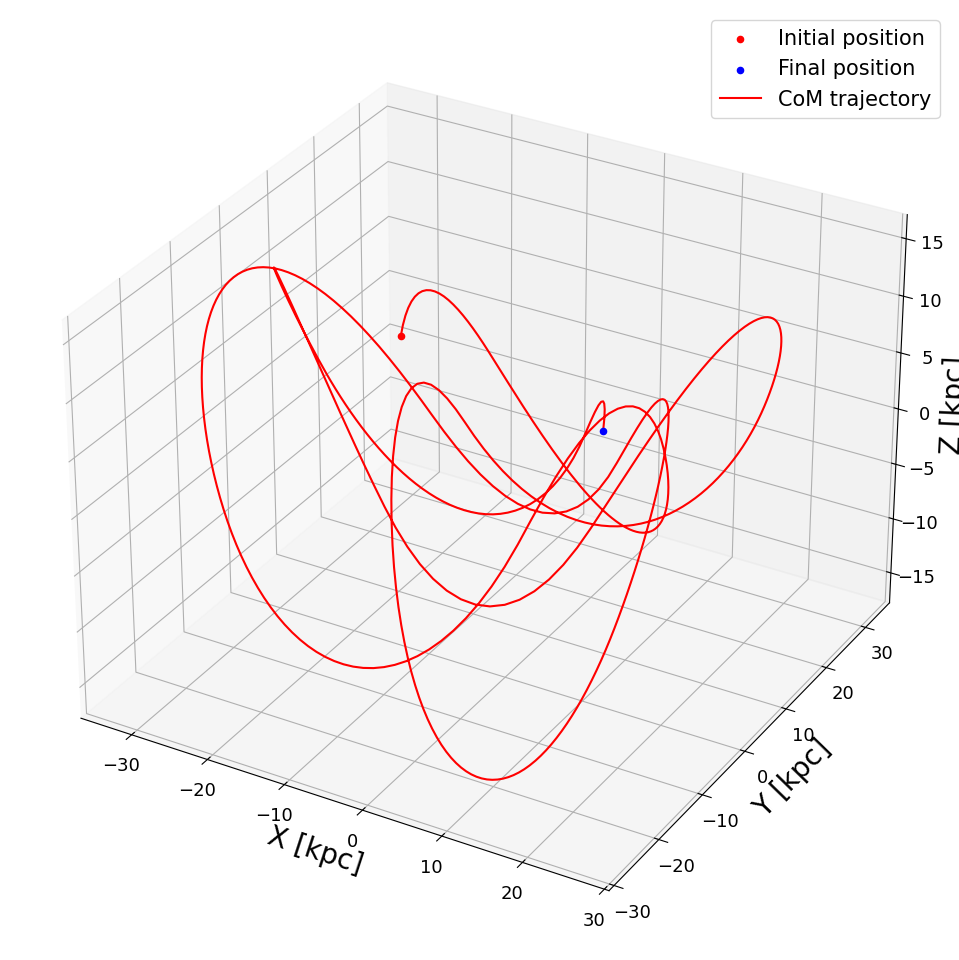

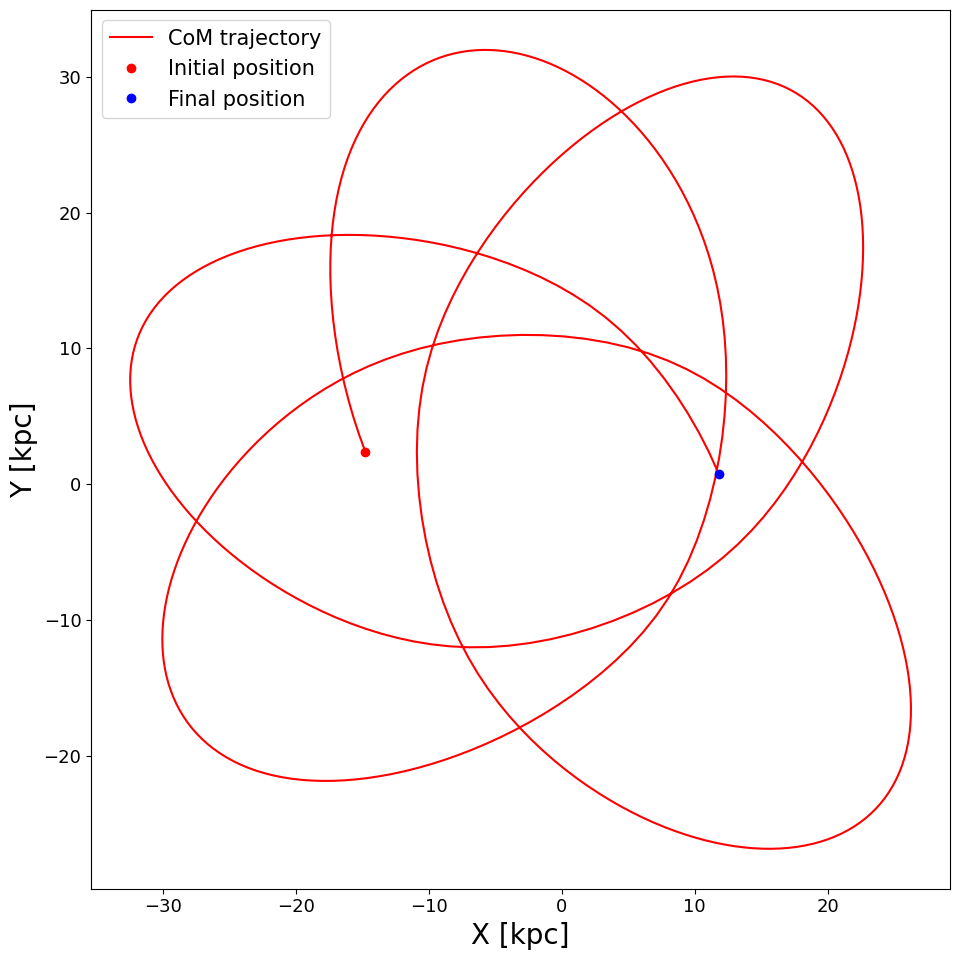

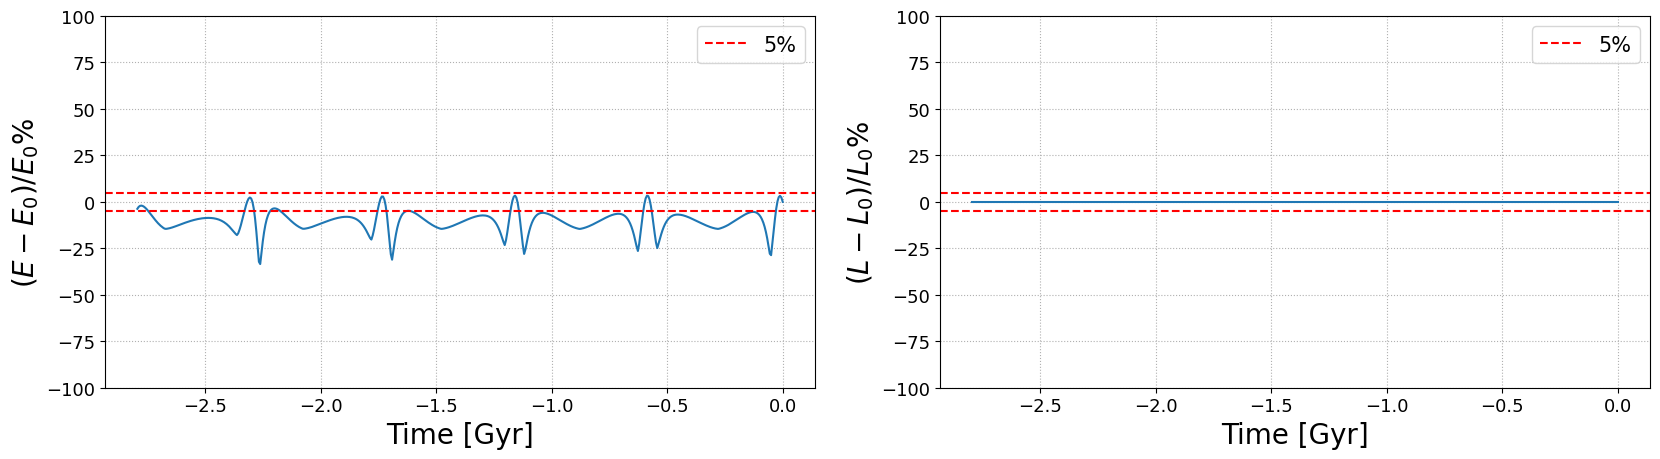

In [4]:
# Define the 
config_com = SimulationConfig(N_particles = 1, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 5000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.000001 * u.kpc).to(code_units.code_length).value) #default values

params_com = SimulationParams(t_end = -(2800 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e4 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1e-3 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.28 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,
                                               c = 15.3),  
                          PSP_params= PSPParams(alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),
                          G=G, ) 


#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)

mass_com = jnp.array([(1e4* u.Msun).to(code_units.code_mass).value])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = jax.block_until_ready(time_integration(primitive_state=final_state_com, mass=mass_com, config=config_com, params=params_com, code_units=code_units))
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0], snapshots_com.states[-1, 0, 0, 1], snapshots_com.states[-1,0, 0, 2],c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0], snapshots_com.states[0, 0, 0, 1], snapshots_com.states[0,0, 0, 2], c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0], snapshots_com.states[:, 0, 0, 1], snapshots_com.states[:,0, 0, 2], 'r-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0], snapshots_com.states[:, 0, 0, 1], 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0], snapshots_com.states[-1, 0, 0, 1], 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0], snapshots_com.states[0, 0, 0, 1], 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [5]:
print('Initial position of the GD1 progenitor:', pos_com)
print('Radial distance of the progenitor:', jnp.linalg.norm(pos_com))
print('Initial velocity of the GD1 progenitor:', vel_com*code_units.code_velocity.to(u.km/u.s))


Initial position of the GD1 progenitor: [[-14.7926855   2.39715     8.95006  ]]
Radial distance of the progenitor: 17.454897
Initial velocity of the GD1 progenitor: [[-87.81396 223.09036  98.40864]]


In [6]:
#run the simulation
snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params, code_units))

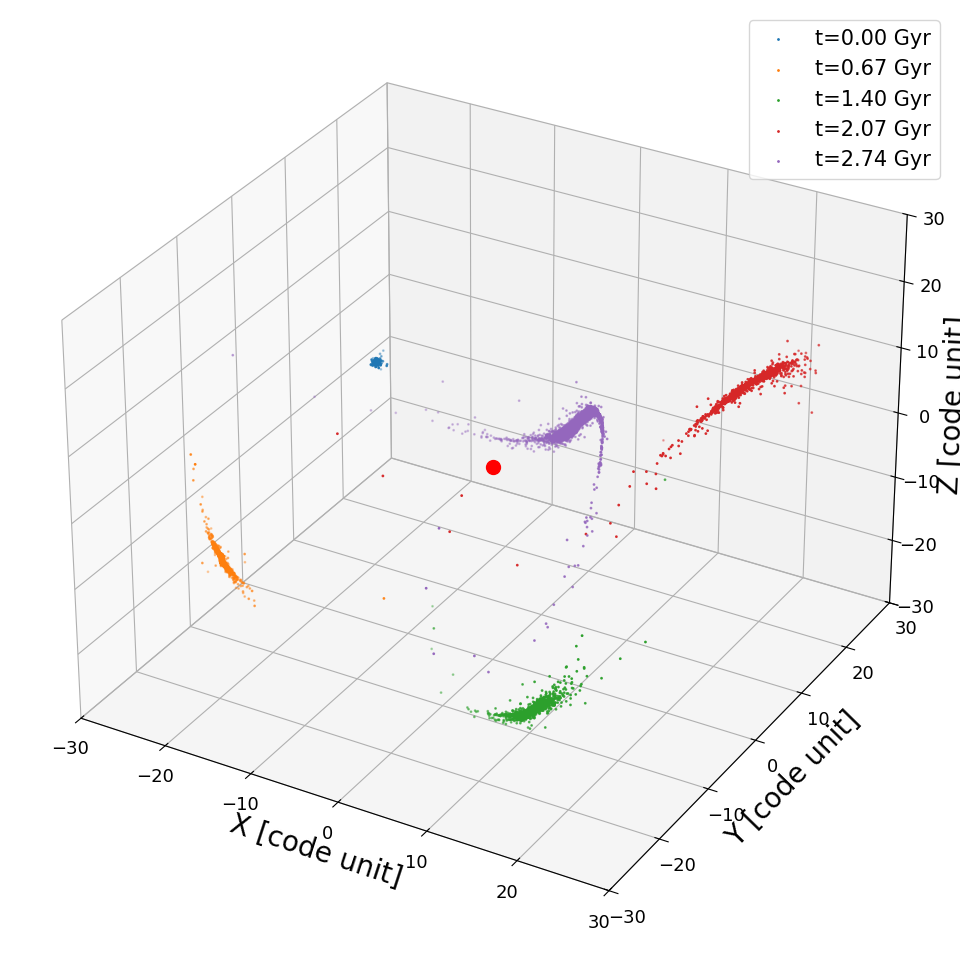

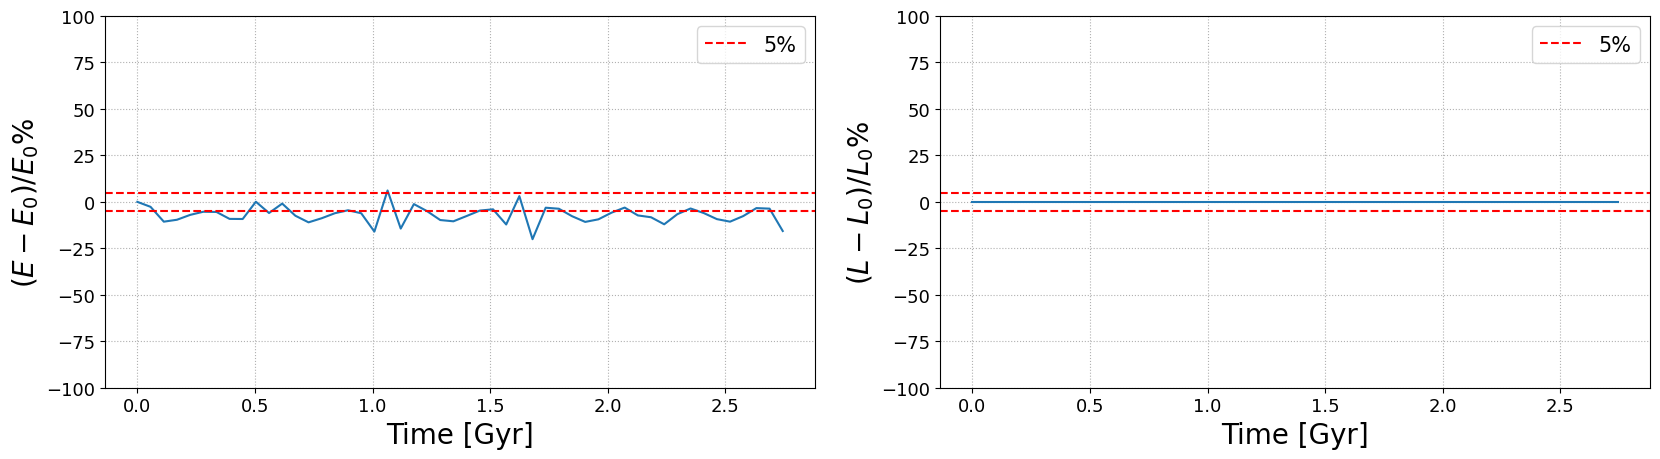

In [7]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0], snapshots.states[i, :, 0, 1], snapshots.states[i, :, 0, 2], s=1,label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='red', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)

ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


In [8]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

# compute the trasformqation to the GD1 coordinate system for 1 star
gd1_coordinate = halo_to_gd1_all(final_positions[0], final_velocities[0], code_units)
print("GD1 coordinate: ", gd1_coordinate)

# compute the transformation to the GD1 coordinate system for all stars
gd1_coordinate_vmapped = gd1_projection_vmap(final_positions, final_velocities, code_units)
print("shape of GD1 coordinate for all stars: ", gd1_coordinate_vmapped.shape)

GD1 coordinate:  [ 1.50102215e+01 -1.06144631e+00  1.80855736e-01 -2.56153703e-01
  1.10845380e-02  1.55167188e-02]
shape of GD1 coordinate for all stars:  (10000, 6)


(6.0, 20.0)

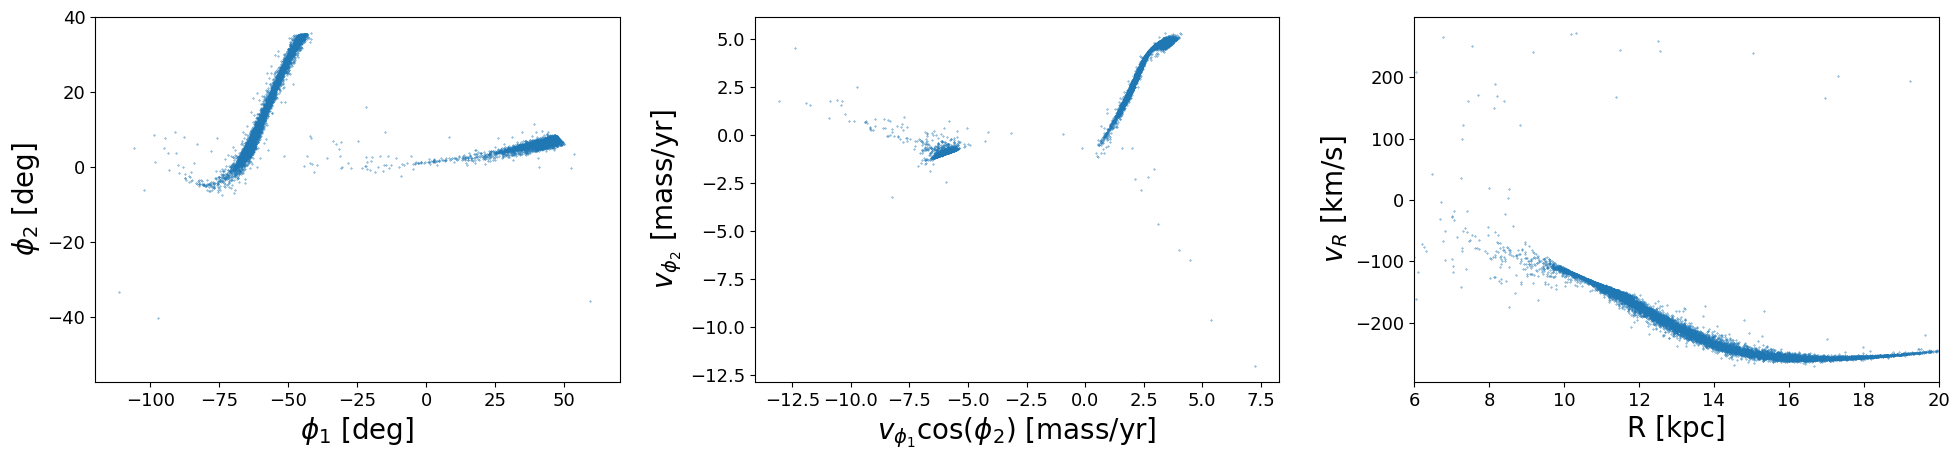

In [9]:
phi1 = jnp.rad2deg(gd1_coordinate_vmapped[:, 1]) #deg
phi2 = jnp.rad2deg(gd1_coordinate_vmapped[:, 2]) #deg
v1 = gd1_coordinate_vmapped[:, 4] #rad/Myr
v2 = gd1_coordinate_vmapped[:, 5] #rad/Myr
R = gd1_coordinate_vmapped[:, 0] #kpc
vR = gd1_coordinate_vmapped[:, 3] #kpc/Myr


fig = plt.figure(figsize=(20, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
# ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1 * jnp.cos(jnp.deg2rad(phi2)) * (u.rad/u.Myr).to(u.mas/u.yr),
           v2 * (u.rad/u.Myr).to(u.mas/u.yr),
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
# ax.set_xlim(-10, 10)
# ax.set_ylim(-5, 5)
# ax.set_xlim(-2., 1.0)
# ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR * (u.kpc / u.Myr).to(u.km/ u.s) , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)



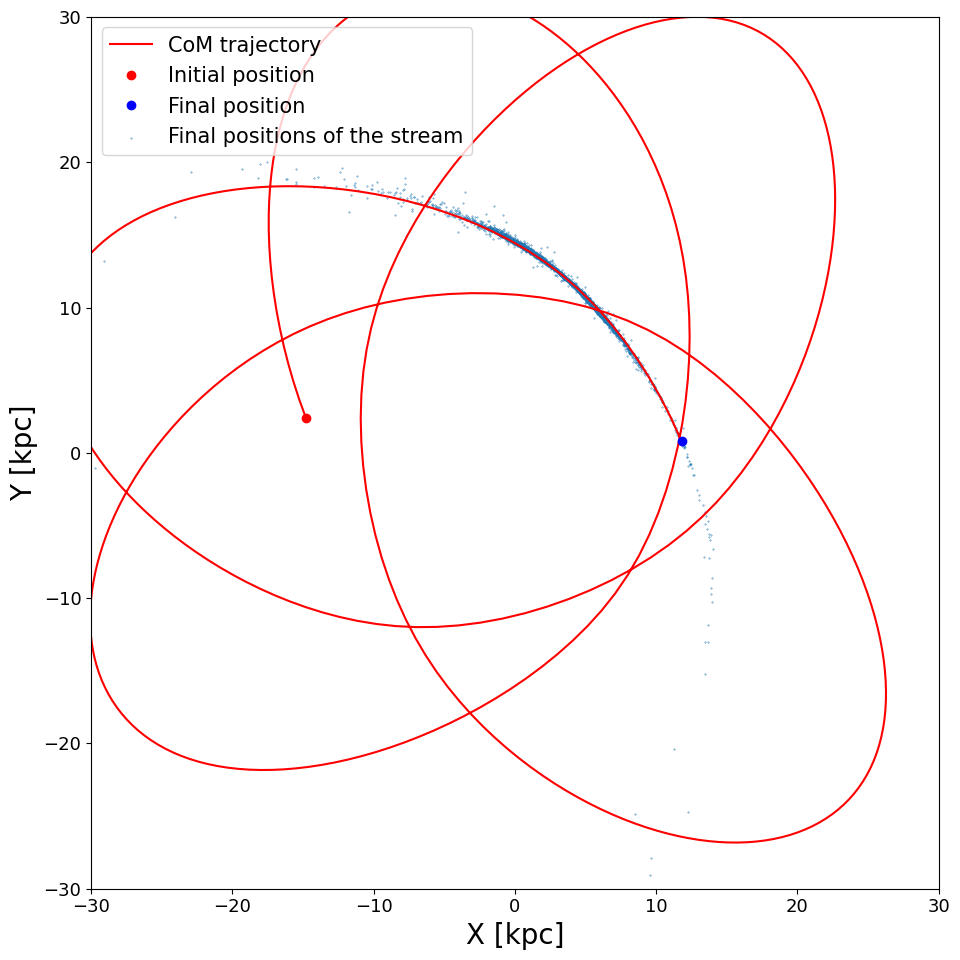

In [10]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0], snapshots_com.states[:, 0, 0, 1], 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0], snapshots_com.states[-1, 0, 0, 1], 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0], snapshots_com.states[0, 0, 0, 1], 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0], snapshots.states[-1, :, 0, 1], s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.legend()

In [12]:
import sstrax
from sstrax import Parameters

params = Parameters()
key = random.PRNGKey(1)
stream = sstrax.simulate_stream(key=key,
                       params=params,)

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)



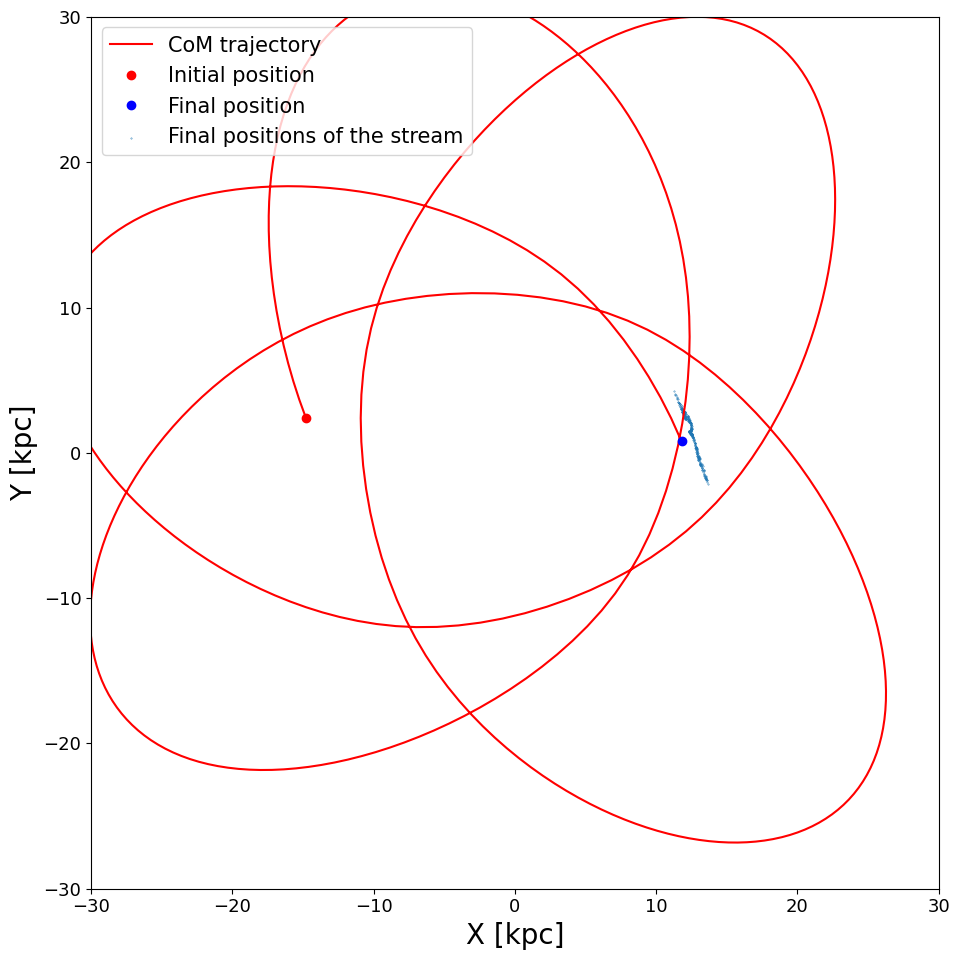

In [13]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0], snapshots_com.states[:, 0, 0, 1], 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0], snapshots_com.states[-1, 0, 0, 1], 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0], snapshots_com.states[0, 0, 0, 1], 'bo', label='Final position')
ax.scatter(stream[:, 0], stream[:, 1], s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.legend()

In [35]:
from sstrax.projection import gd1_projection_vmap

final_state = jnp.array(stream)
final_positions, final_velocities = final_state[:, :3], final_state[:, 3:]

# compute the trasformqation to the GD1 coordinate system for 1 star
# gd1_coordinate = halo_to_gd1_all(final_positions[0], final_velocities[0], code_units)
# print("GD1 coordinate: ", gd1_coordinate)

# compute the transformation to the GD1 coordinate system for all stars
gd1_coordinate_vmapped = gd1_projection_vmap(final_positions, final_velocities)
print("shape of GD1 coordinate for all stars: ", gd1_coordinate_vmapped.shape)

shape of GD1 coordinate for all stars:  (362, 6)


In [37]:
phi1

Array([-15.956001 , -37.321285 , -23.531637 , -26.69606  , -25.931913 ,
       -42.209614 , -16.210194 , -43.446583 , -46.789715 , -17.512697 ,
       -38.047417 , -19.189991 , -23.05791  , -27.253628 , -13.336865 ,
        -8.913877 , -13.280443 , -48.314224 , -23.78136  , -30.372967 ,
       -20.199429 , -20.823452 , -20.035467 , -49.632088 ,  -7.282758 ,
       -29.63206  , -20.382223 , -33.07661  , -32.7434   , -18.611576 ,
       -15.498258 , -14.280809 , -21.25975  , -25.796982 , -17.431843 ,
       -15.609341 , -48.009457 , -38.18528  , -33.718822 , -36.192616 ,
       -25.427511 , -16.396585 , -24.23592  , -24.9944   , -15.02227  ,
       -41.745956 , -25.268822 , -23.47084  , -10.802692 , -19.570284 ,
       -25.355917 , -23.190372 , -42.090527 , -20.288902 , -41.552074 ,
       -24.719265 , -33.239983 , -27.86604  , -23.85491  , -25.69109  ,
       -23.960146 , -48.96495  , -20.644238 ,  -5.6596437,  -9.04361  ,
       -14.450292 , -23.947973 , -20.515879 ,  -6.992212 , -28.2

Text(0, 0.5, '$v_R$ [km/s]')

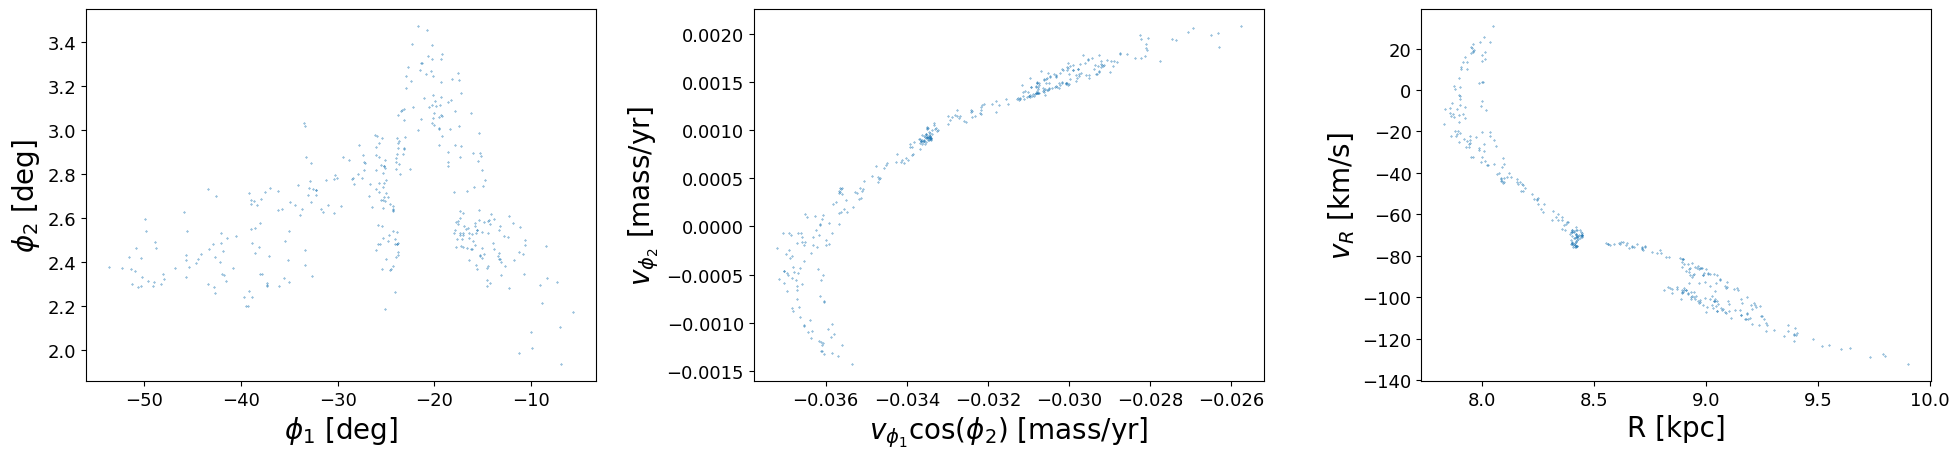

In [41]:
phi1 = jnp.rad2deg(gd1_coordinate_vmapped[:, 1]) #deg
phi2 = jnp.rad2deg(gd1_coordinate_vmapped[:, 2]) #deg
v1 = gd1_coordinate_vmapped[:, 4] #rad/Myr
v2 = gd1_coordinate_vmapped[:, 5] #rad/Myr
R = gd1_coordinate_vmapped[:, 0] #kpc
vR = gd1_coordinate_vmapped[:, 3] #kpc/Myr


fig = plt.figure(figsize=(20, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
# ax.set_xlim(-120, 70)
# ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1 * jnp.cos(jnp.deg2rad(phi2)) ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
# ax.set_xlim(-10, 10)
# ax.set_ylim(-5, 5)
# ax.set_xlim(-2., 1.0)
# ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR * (u.kpc / u.Myr).to(u.km/ u.s) , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
# ax.set_xlim(6, 20)

